<a href="https://colab.research.google.com/github/lucaskydelima/Optimization-with-Python-Pyomo/blob/main/S4Example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyomo

In [3]:
import os
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

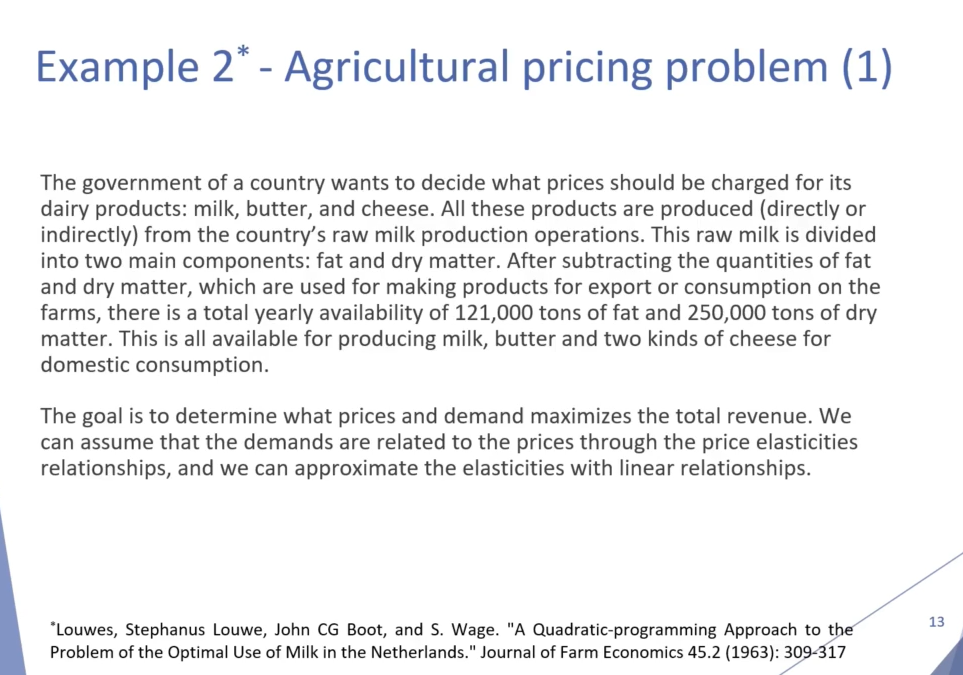

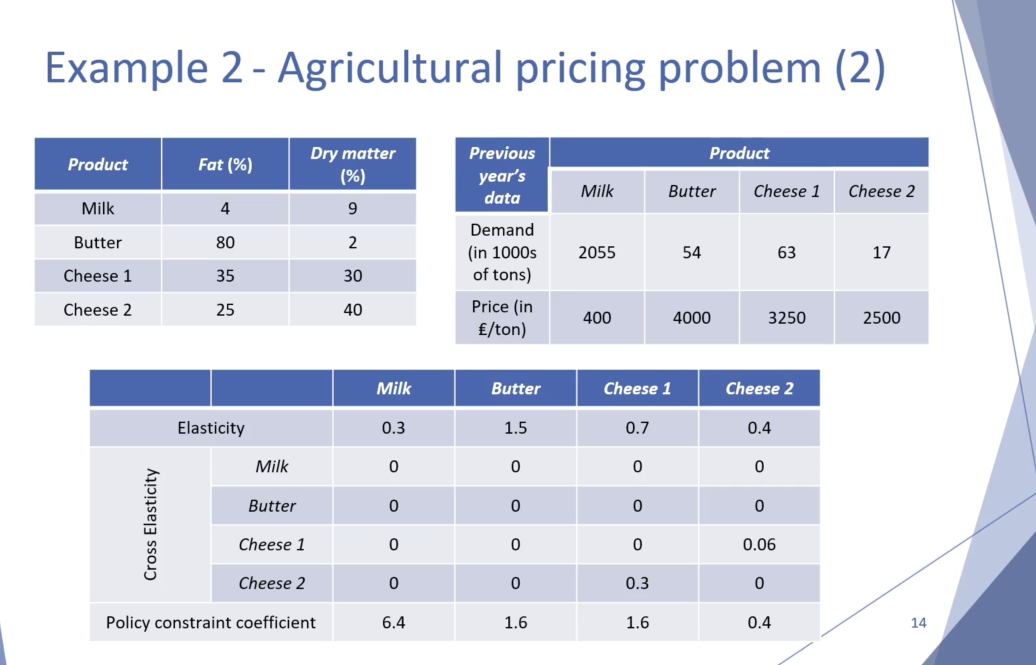

In [10]:
# Defining the model
model = pyo.ConcreteModel()

# Set
model.p = pyo.Set(initialize=['milk', 'butter', 'cheese1', 'cheese2'])

# Params
data = pyo.DataPortal()
data.load(filename='Pyomo_MINLP_example_2_input_data.json')
"""
{	"alpha":{"milk":2.6,"butter":80,"cheese1":30.6,"cheese2":24.5},
	"beta":{"milk":8.6,"butter":2,"cheese1":29.7,"cheese2":37.1},
	"mu":{"milk":2055,"butter":54,"cheese1":63,"cheese2":17},
	"chi":{"milk":400,"butter":4000,"cheese1":3250,"cheese2":2500},
	"epsilon":{"milk":0.3,"butter":1.5,"cheese1":0.7,"cheese2":0.4},
	"rho":{"milk":6.4,"butter":1.6,"cheese1":1.6,"cheese2":0.4},
	"nu":[{"index":["cheese1","cheese2"],"value":0.06},
	          {"index":["cheese2","cheese1"],"value":0.30}
]}
"""
model.alpha = pyo.Param(model.p, initialize=data['alpha'], doc='Fat content')
model.beta = pyo.Param(model.p, initialize=data['beta'], doc='Dry matter  content')

model.mu = pyo.Param(model.p, initialize=data['mu'], doc='Average demand')
model.chi = pyo.Param(model.p, initialize=data['chi'], doc='Average price')

model.epsilon = pyo.Param(model.p, initialize=data['epsilon'], doc='Elasticity')

model.rho = pyo.Param(model.p, initialize=data['rho'], doc='Coefficients for policy constraint')

model.nu = pyo.Param(model.p, model.p, initialize=data['nu'], doc='Cross elasticity')


model.gamma = pyo.Param(initialize=121)
model.theta = pyo.Param(initialize=250)

# Decision Variables
model.x = pyo.Var(model.p, domain=pyo.NonNegativeIntegers)
model.c = pyo.Var(model.p, domain=pyo.NonNegativeReals)

# Constraints
def rule1(model, p):
  return sum((model.alpha[p]/100)*model.x[p] for p in model.p) <= model.gamma
model.const1 = pyo.Constraint(model.p, rule=rule1, doc='Fat content constraint')

def rule2(model, p):
  return sum((model.beta[p]/100)*model.x[p] for p in model.p) <= model.theta
model.const2 = pyo.Constraint(model.p, rule=rule2, doc='Dry matter constraint')

def rule3(model):
  term1 = (model.x['milk'] - model.mu['milk'])/model.mu['milk']
  term2 = -1*model.epsilon['milk']*(model.c['milk']-model.chi['milk'])/model.chi['milk']
  return  term1 == term2
model.const3 = pyo.Constraint(rule=rule3, doc='Linear demand relationship for milk')

def rule4(model):
  term1 = (model.x['butter'] - model.mu['butter'])/model.mu['butter'] 
  term2 = -1*model.epsilon['butter']*(model.c['butter']-model.chi['butter'])/model.chi['butter']
  return term1 == term2 
model.const4 = pyo.Constraint(rule=rule4, doc='Linear demand relationship for butter')

def rule5(model):
  term1 = (model.x['cheese1'] - model.mu['cheese1'])/model.mu['cheese1']
  term2 = -1*model.epsilon['cheese1']*(model.c['cheese1']-model.chi['cheese1'])/model.chi['cheese1']
  term3 = model.nu['cheese1', 'cheese2']*(model.c['cheese2']-model.chi['cheese2'])/model.chi['cheese2']
  return term1 == term2 + term3
model.const5 = pyo.Constraint(rule=rule5, doc='Linear demand relationship for cheese1')

def rule6(model):
  term1 = (model.x['cheese2'] - model.mu['cheese2'])/model.mu['cheese2']
  term2 = -1*model.epsilon['cheese2']*(model.c['cheese2']-model.chi['cheese2'])/model.chi['cheese2']
  term3 = model.nu['cheese2', 'cheese1']*(model.c['cheese1']-model.chi['cheese1'])/model.chi['cheese1']
  return term1 == term2 + term3
model.const6 = pyo.Constraint(rule=rule6, doc='Linear demand relationship for cheese2')

def rule7(model):
  return sum(model.rho[p]*(model.c[p]-model.chi[p])/model.chi[p] for p in model.p) == 0
model.const7 = pyo.Constraint(rule=rule7)

# Objective function
def Objective_rule(model):
  return sum(model.x[p]*model.c[p] for p in model.p)
model.obj = pyo.Objective(rule=Objective_rule, sense=pyo.maximize)

# Solve
os.environ['NEOS_EMAIL'] = 'lucaskydelima@gmail.com'
results = pyo.SolverManagerFactory('neos').solve(model, opt='minlp')

results.write()

print('\nRESULTS')
print('Total revenue =', model.obj())

for p in model.p:
  print('\nAmount of product (',p,') consumed =', model.x[p](),'ktons')

for p in model.p:
  print('\nPrice of product (',p,') =', model.c[p](),'(in 1000s of punds)')

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 13
  Number of variables: 8
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: MINLP-B&B (20100607)\x3a Optimal solution found; 2209 subproblems, objective = 1285250; Evals\x3a obj = 24147, constr = 24194, grad = 12159, Hes = 12208
  Termination condition: optimal
  Id: 0
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solutio

In [ ]:
"""
One strategy one can use to improve solver performance involves use of starting points where initial values are provided for the decision variables within the problem.  
The specification of starting points involving good initial values for the individual variables is important in a NLP/MCP - Mixed complementarity problem, context for a number of reasons.

  • Non-convex models may have multiple solutions and the solvers generally only try to find one local one.  An initial point in the right neighborhood is more likely to return a desirable solution.

  • Initial values that satisfy or closely satisfy many of the constraints reduce the work involved in finding a first feasible solution.

  • Initial values that are close to the optimal ones reduce the work required to find the optimal point and therefore the solution time.

  • The progress of the optimization algorithm is based on good directional information and therefore on good derivatives.  The derivatives in a nonlinear model depend on the current point, and an improved initial point can improve solver performance.

Source: https://www.gams.com/mccarlGuide/starting_points_--_initial_values.htm
"""